In [1]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 10.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%%capture
from PIL import Image
import os
import numpy as np
from pprint import pprint
from tqdm import tqdm #progress bar
import requests
import torch
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoProcessor, LlavaForConditionalGeneration
#from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import csv
import os
import shutil
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
# file path for web scraped data
filepath_pd = '/content/drive/MyDrive/capstone_project/palm_desert.txt'
filepath_cc = '/content/drive/MyDrive/capstone_project/cook_county_recycling_instruc.txt'

# file path for images
imagepath = '/content/drive/MyDrive/capstone_project/image_data/data_x.npy'
# file path for image labels
labelpath = '/content/drive/MyDrive/capstone_project/image_data/data_y.npy'

#filepath for model output
outputpath = '/content/drive/MyDrive/capstone_project/Notebooks/llava_output/bin_class'
outputpath2 = '/content/drive/MyDrive/capstone_project/Notebooks/llava_output/bin_class2'

# getting recycling guide instructions
with open(filepath_pd, "r") as file:
  pd_instruc = file.read()

#with open(filepath_cc, "r") as file:
#  cc_instruc = file.read()

In [ ]:
# getting images (loaded as numpy arrays)
images = np.load(open(imagepath, 'rb'))
labels = np.load(labelpath, allow_pickle=True)

label_names, integer_labels = np.unique(labels, return_inverse=True)

tensor_x = torch.Tensor(images) # transform to torch tensor
tensor_y = torch.tensor(integer_labels).long() #torch.Tensor(shuffled_labels)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size = 3, shuffle=True) # create dataloader

Feature batch shape: torch.Size([3, 128, 128, 3])
Labels batch shape: torch.Size([3])


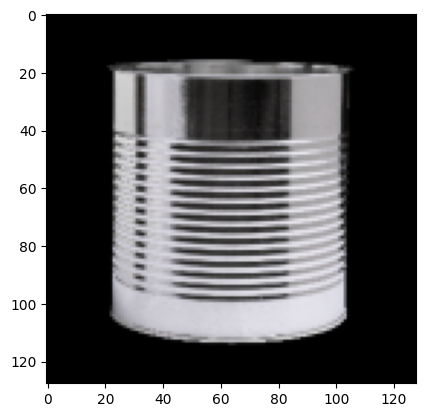

Label: aluminum_can


In [ ]:
# Display image and label
features, labels = next(iter(my_dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].numpy().astype(np.uint8) #.squeeze()
label = labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label_names[label]}")

In [ ]:
unique, counts = np.unique(labels, return_counts=True)

d = dict(zip(unique, counts))
print(d)

{0: 1, 1: 1, 4: 1}


In [10]:
def string_accuracy(actual, predicted):

    # Count the number of correct predictions
    correct_predictions = sum(a == p for a, p in zip(actual, predicted))

    # Calculate accuracy
    accuracy = correct_predictions / len(actual)

    return accuracy

In [6]:
# Function to extract "ASSISTANT" responses
def extract_assistant_response(row):
    response = row['Pred']
    if "ASSISTANT:" in response:
        # Split on "ASSISTANT:" and take the second part, stripping whitespace
        assist = response.find("ASSISTANT:")
        assistant_response = response[assist + 11:].lower()
        if assistant_response == 'box': # replace box with boxes for alignment with labels
          assistant_response = 'boxes'
        return assistant_response
    return None

In [7]:
def get_cm_scores(df, title):
  cm = confusion_matrix(df['Label'], df['Prediction'])

  accuracy = accuracy_score(df['Label'], df['Prediction'])
  precision = precision_score(df['Label'], df['Prediction'], average='weighted')
  recall = recall_score(df['Label'], df['Prediction'], average='weighted')

  plt.figure(figsize=(6, 5))
  unique_classes = sorted(df['Label'].unique())
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title(title)
  plt.show()

  print(f'Accuracy: {accuracy:.2f}')
  print(f'Weighted Precision: {precision:.2f}')
  print(f'Weighted Recall: {recall:.2f}')

In [ ]:
# list of item types in dataset with '_' removed because it slightly improved classification accuracy
captions = [c.replace('_', ' ') for c in label_names]
# need to map the string output back to the original format for comparison with labels
caption_map = {'boxes':'boxes', 'soda can':'soda_can', 'plastic bottle':'plastic_bottle', 'glass bottle':'glass_bottle', 'paper cup':'paper_cup', 'aluminum can':'aluminum_can'}

print(captions)

['aluminum can', 'boxes', 'glass bottle', 'paper cup', 'plastic bottle', 'soda can']


## Bin Classification

In [ ]:
model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
# PROMPTS

#bin_prompt = f"USER: <image>\n{prompt_instruct}\n Should this item be thrown in the recycling bin or trash bin based on the inputted recycling guide?\nASSISTANT:"
#bin_prompt = f"USER: <image>\n{prompt_instruct}\n This is a {shuffled_labels[0]}. Should this be thrown in the recycling bin?\nASSISTANT:"
#bin_prompt = f"USER: <image>\n{prompt_instruct}\n Should this item be recycled based on the inputted recycling guide?\nASSISTANT:"
#bin_prompt = f"USER: <image>\n Should this item be recycled based on the inputted recycling guide?\n{prompt_instruct}\nASSISTANT:"

#prompt_instruct2 = f"Given the following instructions for recycling in {location}: \n The following items can be recycled: {pd_instruc} \n Determine if the item should be disposed of in the recycling or trash."

prompt_instruct2 = f"Given the following instructions: \n The following items can explicitly listed be recycled: {pd_instruc} \n Determine if the item should be disposed of in the recycling or trash."
#bin_prompt = f"USER: <image>\n{prompt_instruct2}\n This is a {labels[b]}. Should this be thrown in the recycling bin?\nASSISTANT:"

In [ ]:
# get model output and save in outputpath (folder)
def get_llava(dataloader, max_new_tokens=100, outputpath=outputpath, temperature=1):
  for b, batch in enumerate(dataloader):
      output_list = []
      label_list = []

      prompts = []
      images, labels = batch

      for l in labels:
        prompt = bin_prompt = f"USER: <image>\n{prompt_instruct2}\n This is a {l}. Should this be thrown in the recycling bin? Remember, paper cups cannot be recycled\nASSISTANT:"
        prompts.append(prompt)

      # Process the inputs
      inputs = processor(text=prompts,
                        images=images,
                        return_tensors='pt').to(0, torch.float16)

      # Run inference
      with torch.no_grad():
          outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False, temperature=temperature)

      decoded_output = processor.batch_decode(outputs, skip_special_tokens=True)

      output_list.append(decoded_output)
      output_list = sum(output_list, []) # flatten list

      label_caption = [label_names[l] for l in labels] # getting text version of label
      label_list.append(label_caption)
      label_list = sum(label_list, []) # flatten list

      # Specify the filename
      filename = f'output_{b}_batch.csv'

      # Write to the CSV file
      with open(filename, mode='w', newline='') as file:
          writer = csv.writer(file)
          writer.writerow(['Pred', 'Label'])
          for item1, item2 in zip(output_list, label_list):
            writer.writerow([item1, item2])

      shutil.copy(filename, outputpath)

      print(f'Data exported to {filename}') # should get to 176 batches with batch length = 3 (30 min)

### Prompt 1

In [11]:
# grab and concat output
df_concat = pd.concat([pd.read_csv(os.path.join(outputpath, f)) for f in os.listdir(outputpath)])

# Apply the function and create a new column
df_concat['Prediction'] = df_concat.apply(extract_assistant_response, axis=1)

df = df_concat[['Prediction', 'Label']].reset_index(drop=True)
df['Label'] = df['Label'].str.replace('_', ' ', regex=False)

# Display the resulting DataFrame
df.head()

,Prediction,Label
0,"based on the instructions provided, the item s...",glass bottle
1,"based on the instructions provided, the item s...",plastic bottle
2,"based on the instructions provided, the cup sh...",paper cup
3,"based on the instructions provided, the item s...",glass bottle
4,"yes, the item should be disposed of in the rec...",soda can


In [12]:
# recycling guide "key" (reycleable = Yes)
pd_recyling = {'glass bottle':'Yes', 'plastic bottle':'Yes', 'paper cup':'No', 'soda can':'Yes', 'boxes':'Yes', 'aluminum can':'Yes'}

df['Bin'] = 'No'  # Default value
df.loc[df['Prediction'].str.contains('should be disposed of in the recycling bin'), 'Bin'] = 'Yes' # adding a bin prediction col

# actual label based off of hard coded recycling guide
df['Actual'] = df['Label'].map(pd_recyling)

df.head()

,Prediction,Label,Bin,Actual
0,"based on the instructions provided, the item s...",glass bottle,Yes,Yes
1,"based on the instructions provided, the item s...",plastic bottle,Yes,Yes
2,"based on the instructions provided, the cup sh...",paper cup,Yes,No
3,"based on the instructions provided, the item s...",glass bottle,Yes,Yes
4,"yes, the item should be disposed of in the rec...",soda can,Yes,Yes


In [13]:
accuracy = (df['Bin'] == df['Actual']).sum()/len(df['Prediction'])
print('Bin classification accuracy:', accuracy)

Bin classification accuracy: 0.7920604914933838


In [14]:
df_gb = df[df['Label']=='glass bottle']
df_pb = df[df['Label']=='plastic bottle']
df_pc = df[df['Label']=='paper cup']
df_sc = df[df['Label']=='soda can']
df_b = df[df['Label']=='boxes']
df_ac = df[df['Label']=='aluminum can']

accuracy_gb = (df_gb['Bin'] == df_gb['Actual']).sum()/len(df_gb['Prediction'])
accuracy_pb = (df_pb['Bin'] == df_pb['Actual']).sum()/len(df_pb['Prediction'])
accuracy_pc = (df_pc['Bin'] == df_pc['Actual']).sum()/len(df_pc['Prediction'])
accuracy_sc = (df_sc['Bin'] == df_sc['Actual']).sum()/len(df_sc['Prediction'])
accuracy_b = (df_b['Bin'] == df_b['Actual']).sum()/len(df_b['Prediction'])
accuracy_ac = (df_ac['Bin'] == df_ac['Actual']).sum()/len(df_ac['Prediction'])

print('Glass Bottle Bin classification accuracy:', accuracy_gb)
print('Plastic Bottle Bin classification accuracy:', accuracy_pb)
print('Paper Cup Bin classification accuracy:', accuracy_pc)
print('Soda Can Bin classification accuracy:', accuracy_sc)
print('Boxes Bin classification accuracy:', accuracy_b)
print('Aluminum Can Bin classification accuracy:', round(accuracy_ac, 2))

Glass Bottle Bin classification accuracy: 0.94
Plastic Bottle Bin classification accuracy: 0.98
Paper Cup Bin classification accuracy: 0.0
Soda Can Bin classification accuracy: 0.98
Boxes Bin classification accuracy: 0.93
Aluminum Can Bin classification accuracy: 0.51


In [15]:
# replace aluminum can with aluminum tin can
df_ac

,Prediction,Label,Bin,Actual
21,"based on the instructions provided, the item s...",aluminum can,Yes,Yes
25,"based on the instructions provided, the item s...",aluminum can,Yes,Yes
45,no.,aluminum can,No,Yes
52,no.,aluminum can,No,Yes
67,no.,aluminum can,No,Yes
...,...,...,...,...
510,no.,aluminum can,No,Yes
516,no.,aluminum can,No,Yes
522,no.,aluminum can,No,Yes
523,"based on the instructions provided, the item s...",aluminum can,Yes,Yes


In [16]:
report = classification_report(df['Actual'], df['Bin'])
print(report)

              precision    recall  f1-score   support

          No       0.00      0.00      0.00        59
         Yes       0.88      0.89      0.88       470

    accuracy                           0.79       529
   macro avg       0.44      0.45      0.44       529
weighted avg       0.78      0.79      0.79       529



### Prompt 2

In [ ]:
prompt_instruct2 = f"Given the following instructions: \n The following items can explicitly listed be recycled: {pd_instruc} \n Determine if the item should be disposed of in the recycling or trash. For example, input: 'paper cup', output:'no'."

In [ ]:
get_llava(my_dataloader, max_new_tokens=30, temperature=0.5)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:228: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


Data exported to output_0_batch.csv


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Data exported to output_1_batch.csv
Data exported to output_2_batch.csv
Data exported to output_3_batch.csv
Data exported to output_4_batch.csv
Data exported to output_5_batch.csv
Data exported to output_6_batch.csv
Data exported to output_7_batch.csv
Data exported to output_8_batch.csv
Data exported to output_9_batch.csv
Data exported to output_10_batch.csv
Data exported to output_11_batch.csv
Data exported to output_12_batch.csv
Data exported to output_13_batch.csv
Data exported to output_14_batch.csv
Data exported to output_15_batch.csv
Data exported to output_16_batch.csv
Data exported to output_17_batch.csv
Data exported to output_18_batch.csv
Data exported to output_19_batch.csv
Data exported to output_20_batch.csv
Data exported to output_21_batch.csv
Data exported to output_22_batch.csv
Data exported to output_23_batch.csv
Data exported to output_24_batch.csv
Data exported to output_25_batch.csv
Data exported to output_26_batch.csv
Data exported to output_27_batch.csv
Data expor

In [8]:
# grab and concat output
df_concat = pd.concat([pd.read_csv(os.path.join(outputpath2, f)) for f in os.listdir(outputpath2)])

# Apply the function and create a new column
df_concat['Prediction'] = df_concat.apply(extract_assistant_response, axis=1)

df = df_concat[['Prediction', 'Label']].reset_index(drop=True)
df['Label'] = df['Label'].str.replace('_', ' ', regex=False)

# Display the resulting DataFrame
df.head()

,Prediction,Label
0,"based on the instructions provided, the item s...",glass bottle
1,no.,aluminum can
2,no.,aluminum can
3,"based on the instructions provided, the item s...",glass bottle
4,no.,paper cup


In [9]:
# recycling guide "key" (reycleable = Yes)
pd_recyling = {'glass bottle':'Yes', 'plastic bottle':'Yes', 'paper cup':'No', 'soda can':'Yes', 'boxes':'Yes', 'aluminum can':'Yes'}

df['Bin'] = 'No'  # Default value
df.loc[df['Prediction'].str.contains('should be disposed of in the recycling bin'), 'Bin'] = 'Yes' # adding a bin prediction col

# actual label based off of hard coded recycling guide
df['Actual'] = df['Label'].map(pd_recyling)

df.head()

,Prediction,Label,Bin,Actual
0,"based on the instructions provided, the item s...",glass bottle,Yes,Yes
1,no.,aluminum can,No,Yes
2,no.,aluminum can,No,Yes
3,"based on the instructions provided, the item s...",glass bottle,Yes,Yes
4,no.,paper cup,No,No


In [10]:
df_gb = df[df['Label']=='glass bottle']
df_pb = df[df['Label']=='plastic bottle']
df_pc = df[df['Label']=='paper cup']
df_sc = df[df['Label']=='soda can']
df_b = df[df['Label']=='boxes']
df_ac = df[df['Label']=='aluminum can']

accuracy_gb = (df_gb['Bin'] == df_gb['Actual']).sum()/len(df_gb['Prediction'])
accuracy_pb = (df_pb['Bin'] == df_pb['Actual']).sum()/len(df_pb['Prediction'])
accuracy_pc = (df_pc['Bin'] == df_pc['Actual']).sum()/len(df_pc['Prediction'])
accuracy_sc = (df_sc['Bin'] == df_sc['Actual']).sum()/len(df_sc['Prediction'])
accuracy_b = (df_b['Bin'] == df_b['Actual']).sum()/len(df_b['Prediction'])
accuracy_ac = (df_ac['Bin'] == df_ac['Actual']).sum()/len(df_ac['Prediction'])

print('Glass Bottle Bin classification accuracy:', accuracy_gb)
print('Plastic Bottle Bin classification accuracy:', accuracy_pb)
print('Paper Cup Bin classification accuracy:', accuracy_pc)
print('Soda Can Bin classification accuracy:', accuracy_sc)
print('Boxes Bin classification accuracy:', accuracy_b)
print('Aluminum Can Bin classification accuracy:', round(accuracy_ac, 2))

Glass Bottle Bin classification accuracy: 0.31
Plastic Bottle Bin classification accuracy: 0.34
Paper Cup Bin classification accuracy: 1.0
Soda Can Bin classification accuracy: 0.15
Boxes Bin classification accuracy: 0.01
Aluminum Can Bin classification accuracy: 0.0


In [11]:
report = classification_report(df['Actual'], df['Bin'])
print(report)

              precision    recall  f1-score   support

          No       0.13      1.00      0.23        59
         Yes       1.00      0.17      0.29       470

    accuracy                           0.26       529
   macro avg       0.57      0.59      0.26       529
weighted avg       0.90      0.26      0.29       529



## Part 3: Recycling Instructions

array([[[142, 119,  87],
        [142, 119,  87],
        [142, 119,  87],
        ...,
        [138, 115,  83],
        [137, 114,  82],
        [136, 113,  81]],

       [[142, 119,  87],
        [142, 119,  87],
        [142, 119,  87],
        ...,
        [138, 115,  83],
        [137, 114,  82],
        [137, 114,  82]],

       [[142, 119,  87],
        [142, 119,  87],
        [142, 119,  87],
        ...,
        [139, 116,  84],
        [138, 115,  83],
        [138, 115,  83]],

       ...,

       [[143, 120,  88],
        [143, 120,  88],
        [143, 120,  88],
        ...,
        [148, 124,  90],
        [145, 121,  87],
        [143, 119,  85]],

       [[143, 120,  88],
        [143, 120,  88],
        [143, 120,  88],
        ...,
        [147, 123,  89],
        [145, 121,  87],
        [143, 119,  85]],

       [[143, 120,  88],
        [143, 120,  88],
        [143, 120,  88],
        ...,
        [147, 123,  89],
        [145, 121,  87],
        [143, 119,  85]]], dtype=uint8)
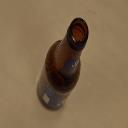

In [ ]:
img

In [ ]:
inputs = processor(img, prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
decoded_output = processor.decode(output[0], skip_special_tokens=True)
#assist = decoded_output.find('ASSISTANT:')
#instructs.append(decoded_output[assist:])
print(decoded_output)

chlorophyll


### OLD

In [ ]:
# check if there is a better way to apply this

item_type = []
bin = []
instructs = [] # starting with this only

# probably the slowest way to do it so need to optimize
i=0
while i < 3:
  for img in images:
    inputs = processor(prompt, img, return_tensors='pt').to(0, torch.float16)
    output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
    decoded_output = processor.decode(output[0][2:], skip_special_tokens=True)
    assist = decoded_output.find('ASSISTANT:')
    instructs.append(decoded_output[assist:])
    i += 1
  #break

In [ ]:
prompt = f"USER: <image>\n{prompt_w_instruc}\nWhat is in the image and can it be recycled, assume things not in instructions cannot be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling in Palm Desert: \n'
 ' What Items Can Be Recycled\n'
 '\n'
 'Paper\t\n'
 '- White and colored paper\n'
 '- Phone books\n'
 '- Magazines\n'
 '- Junk Mail\n'
 '- Envelopes\n'
 '- File folders\n'
 '- Cardboard (flattened)\n'
 '- Cartons (milk, juice, & broth)\n'
 '- Books (remove hard covers or binding)\n'
 '- Cardboard boxes, e.g. cereal, etc.\n'
 '\n'
 'Plastic\n'
 '- Styrofoam packing blocks\n'
 '- Plastic medicine bottles (empty)\n'
 '- Plastic bottles numbered 1-7 (remove plastic film or wrap)\n'
 '\n'
 'Metal & Glass\n'
 '- Aluminum, steel, and tin cans\n'
 '- Clean aluminum foil\n'
 '- Glass bottles and jars (remove lids)\n'
 'What is in the image and can it be recycled, assume things not in '
 'instructions cannot be recycled?\n'
 'ASSISTANT: In the image, there is a white cup made of paper. Based on the '
 'instructions provided, the cup can be recycled as it is made of paper. '
 'However, it is important to note that ot

In [ ]:
## aluminum can

prompt = f"USER: <image>\n{prompt_w_instruc}\nWhat is in the image and can it be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im_2, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling in Palm Desert: \n'
 ' What Items Can Be Recycled\n'
 '\n'
 'Paper\t\n'
 '- White and colored paper\n'
 '- Phone books\n'
 '- Magazines\n'
 '- Junk Mail\n'
 '- Envelopes\n'
 '- File folders\n'
 '- Cardboard (flattened)\n'
 '- Cartons (milk, juice, & broth)\n'
 '- Books (remove hard covers or binding)\n'
 '- Cardboard boxes, e.g. cereal, etc.\n'
 '\n'
 'Plastic\n'
 '- Styrofoam packing blocks\n'
 '- Plastic medicine bottles (empty)\n'
 '- Plastic bottles numbered 1-7 (remove plastic film or wrap)\n'
 '\n'
 'Metal & Glass\n'
 '- Aluminum, steel, and tin cans\n'
 '- Clean aluminum foil\n'
 '- Glass bottles and jars (remove lids)\n'
 'What is in the image and can it be recycled?\n'
 'ASSISTANT: The image features a canned food item, which is typically made of '
 'metal. This can be recycled as part of the metal and glass recycling '
 'category. To recycle the can, it should be removed from the food item and '
 'placed in a recycli

In [ ]:
with open("cook_county_recycling_instruc.txt", "r", encoding = 'utf-8') as file:
  cc_instruc = file.read()

In [ ]:
prompt_start_w_instruc = f"Given the following instructions for recycling: \n {cc_instruc}"

In [ ]:
prompt = f"USER: <image>\n{prompt_start_w_instruc}\nWhat is in the image and can it be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling: \n'
 ' FAQs: Recycling and Proper Disposal CAPS  \n'
 '      \n'
 '\n'
 '  Credit: Recycle by City Always replace your cap onto the empty and clean '
 'plastic bottle it came from. Then, place into your recycling bin to ensure '
 'both plastic components are successfully processed at your local recycling '
 'facility. CLEAN, EMPTY AND DRY RECYCLABLES\n'
 '      \n'
 '\n'
 '  Before you place your recyclable item into your bin, rinse it clean and '
 'allow it to dry. Soap is not necessary. Clean recyclables reduce '
 'contamination of recycling batches. Contamination can result in recyclable '
 'materials being sent to the landfill.SHREDDED PAPER\n'
 '      \n'
 '\n'
 '  Shredded paper should not be placed in your curbside recycling bin. The '
 'small size of the fragmented pieces does not allow for proper sorting at the '
 'recycling facility. Generally, items smaller than a credit card should not '
 'be put in the recycling 

In [ ]:
# aluminum can image experimentation

prompt = f"USER: <image>\n{prompt_start_w_instruc}\nWhat is in the image and can it be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im_2, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling: \n'
 ' FAQs: Recycling and Proper Disposal CAPS  \n'
 '      \n'
 '\n'
 '  Credit: Recycle by City Always replace your cap onto the empty and clean '
 'plastic bottle it came from. Then, place into your recycling bin to ensure '
 'both plastic components are successfully processed at your local recycling '
 'facility. CLEAN, EMPTY AND DRY RECYCLABLES\n'
 '      \n'
 '\n'
 '  Before you place your recyclable item into your bin, rinse it clean and '
 'allow it to dry. Soap is not necessary. Clean recyclables reduce '
 'contamination of recycling batches. Contamination can result in recyclable '
 'materials being sent to the landfill.SHREDDED PAPER\n'
 '      \n'
 '\n'
 '  Shredded paper should not be placed in your curbside recycling bin. The '
 'small size of the fragmented pieces does not allow for proper sorting at the '
 'recycling facility. Generally, items smaller than a credit card should not '
 'be put in the recycling 